# Principal Component Analysis (PCA)

In this notebook, we will implement PCA. We will break down the task of implementing PCA into small components and combine them in the end to produce the final algorithm.

### Importing libraries

DO NOT import any other libraries. These should be sufficient to implement PCA so that we can learn PCA from scratch.

In [1]:
# importing libraries

import os
import sys 
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split

### Loading dataset

PCA is used when we need to tackle the curse of dimensionality among data with linear relationships , i.e. where having too many dimensions (features) in your data causes noise and difficulties.

For the sake of visually being able to see that our algorthm works or not, we will work with image data.

In [2]:
# Loading data and reducing size to 32 x 32 pixels
 
IMG_DIR = './Anime images 1000'    #  YOUR CODE HERE   -  Edit the path for dataset  
print("Loading...")
X = []
X_flat = []
count = 1
total_samples = 200
image_size = 32
for img in os.listdir(IMG_DIR):
    if count == total_samples + 1:
        break
    sys.stdout.write("\r" + str(count) + " / " + str(total_samples))
    sys.stdout.flush()
    img_array = cv.imread(os.path.join(IMG_DIR,img), cv.IMREAD_GRAYSCALE)
    img_pil = Image.fromarray(img_array)
    img_48x48 = np.array(img_pil.resize((image_size, image_size), Image.ANTIALIAS))
    X.append(img_48x48)
    img_array = img_48x48.flatten()
    X_flat.append(img_array)
    count += 1
print()
print("Done!")

Loading...
200 / 200
Done!


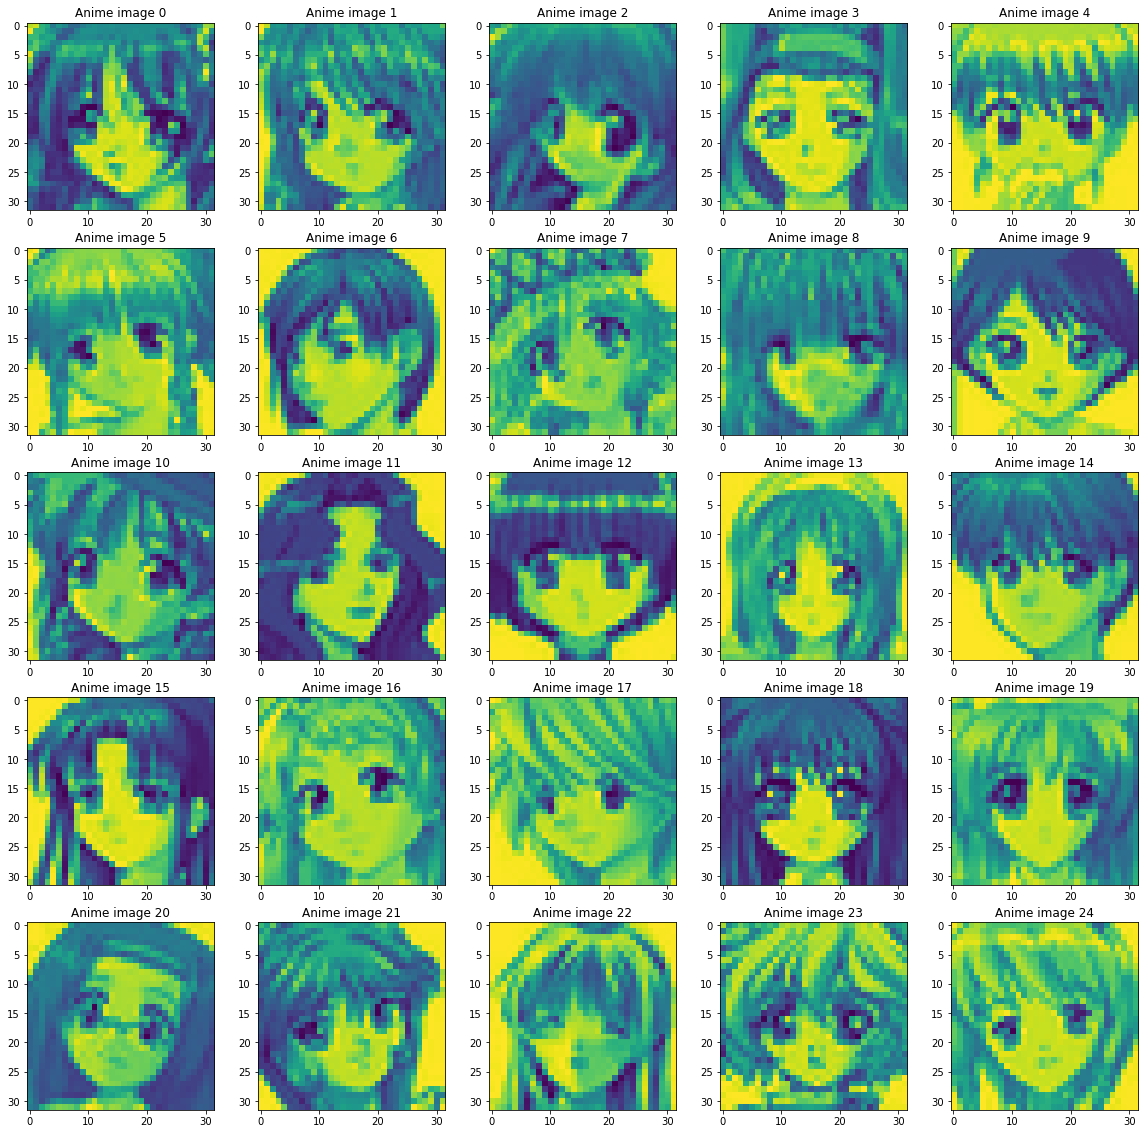

In [3]:
# visualizing some images

fig, ax = plt.subplots(figsize = (20, 20))
for i in range(1, 26):
    plt.subplot(5, 5, i)
    plt.title('Anime image {}'.format(i-1))
    plt.imshow(X[i-1])

In [4]:
# converting X_flat to numpy array

X_flat = np.asarray(X_flat)
X_flat.shape

(200, 1024)

In [5]:
# Test-Train split

X_train, X_test = train_test_split(X_flat, test_size = 0.125, random_state = 42)
X_train = X_train.T
X_test = X_test.T
print(X_train.shape)
print(X_test.shape)

(1024, 175)
(1024, 25)


### PCA

The steps needed to compute PCA are broken into following parts

1. Data standardization.
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix $\boldsymbol S$. Sort by the largest eigenvalues and the corresponding eigenvectors (eig).

3. Compute the projection and reconstruction of the data onto the space spanned by the top $M$ eigenvectors.

In [6]:
# function for standardizing image

def Standardize(X):
    
    # calculate the mean along each feature dimension
    # note that data is stored as column vectors
    
    # YOUR CODE HERE
    mu = np.mean(X,axis=1)
    
    # substract the mean vector from every data vector
    
    # YOUR CODE HERE
    Xbar1=X.T-np.mean(X,axis=1)
    
    
    return Xbar1.T, mu

In [7]:
# check if standardization is correct

X1 = np.diag([1, 3, 5])
Xbar1, mu1 = Standardize(X1)
assert np.isclose(mu1, [0.33, 1., 1.66], atol = 0.05).all()
assert np.isclose(Xbar1, [[0.66, -0.33, -0.33], [-1., 2., -1.], [-1.66, -1.66, 3.33]], atol = 0.05).all()


In [8]:
# function for calculating eigen values and eigen vectors

def eig(S):
    
    # calculate the eigen values and eigen vectors input covariance matrix S
    
    # YOUR CODE HERE
    eig_val, eig_vec = np.linalg.eigh(S)
    
    # sort the eigen values in decreasing order and pick corresponding eigen vectors
    
    # YOUR CODE HERE
    for i in range(0,len(eig_val)):
        for j in range(0,len(eig_val)-1):
            if eig_val[j]<eig_val[j+1]:
                eig_val[j],eig_val[j+1]=eig_val[j+1],eig_val[j]
                eig_vec[:,[j,j+1]]=eig_vec[:,[j+1,j]]
    
    return eig_val, eig_vec

In [9]:
# check if eigen values and eigen vectors are correct

X1 = np.diag([1, 3, 5])
eig_val1, eig_vec1 = eig(X1)
assert np.isclose(eig_val1, [5, 3, 1], atol = 0.05).all()
assert np.isclose(eig_vec1, [[0, 0, 1], [0, 1, 0], [1, 0, 0]], atol = 0.05).all()


In [10]:
# function for projection matrix

def projection_matrix(B):
    
    # calculate the projection matrix P
    
    # YOUR CODE HERE
    P=B.dot(B.T)
    
    return P

In [11]:
# check if projection matrix is correct

X1 = np.diag([1, 3, 5])
assert np.isclose(projection_matrix(X1), [[1, 0, 0], [0, 9, 0], [0, 0, 25]], atol = 0.05).all()


In [12]:
# implementing PCA

def PCA(X, num_components):
    
    # calculate the data covariance matrix S. The input matrix X will have mean corrected entries
    
    # YOUR CODE HERE
    S=(X@X.T)/len(X)

    
    # now find eigenvalues and corresponding eigenvectors for S by implementing eig().
    eig_vals, eig_vecs = eig(S)
    
    # select eigen vectors
    U = eig_vecs[:, range(num_components)]
    
    # reconstruct the images from the lowerdimensional representation
    # to do this, we first need to find the projection_matrix (which you implemented earlier)
    # which projects our input data onto the vector space spanned by the eigenvectors
    P = projection_matrix(U) # projection matrix
    
    return P

In [13]:
# Check if PCA is correct

X1 = np.diag([1, 3, 5])
num_components1 = 2
X1, mu = Standardize(X1)
assert np.isclose(PCA(X1, num_components1), [[0.13, -0.28, -0.17], [-0.28, 0.90, -0.05], [-0.17, -0.05, 0.96]], atol = 0.05).all()


### Standardization

Now, with the help of the functions you have implemented above, let's implement PCA!

In [14]:
# standardizing

Xbar_train, mu_train = Standardize(X_train)
Xbar_test, mu_test = Standardize(X_test)

In [15]:
# function for mean square error

def mse(predict, actual):
    return np.square(predict - actual).mean()

### Loss and Reconstruction

In [16]:
# calculating loss and reconstructing images

loss = []
reconstructions = []
max_components = len(X_train.T)
print("Processing...")
animation = np.arange(1, max_components + 1, 1)
for num_component in range(1, max_components + 1):
    sys.stdout.write("\r" + str(animation[num_component - 1]) + " / " + str(max_components))
    sys.stdout.flush()
    projection = PCA(Xbar_train, num_component)
    reconst = projection @ Xbar_test
    error = mse((reconst.T + mu_test).T, X_test)
    reconstructions.append(reconst)
    loss.append((num_component, error))
print()
print("Done!")

Processing...
175 / 175
Done!


In [17]:
# converting reconstructions and loss to numpy arrays

reconstructions = np.asarray(reconstructions)
loss = np.asarray(loss)

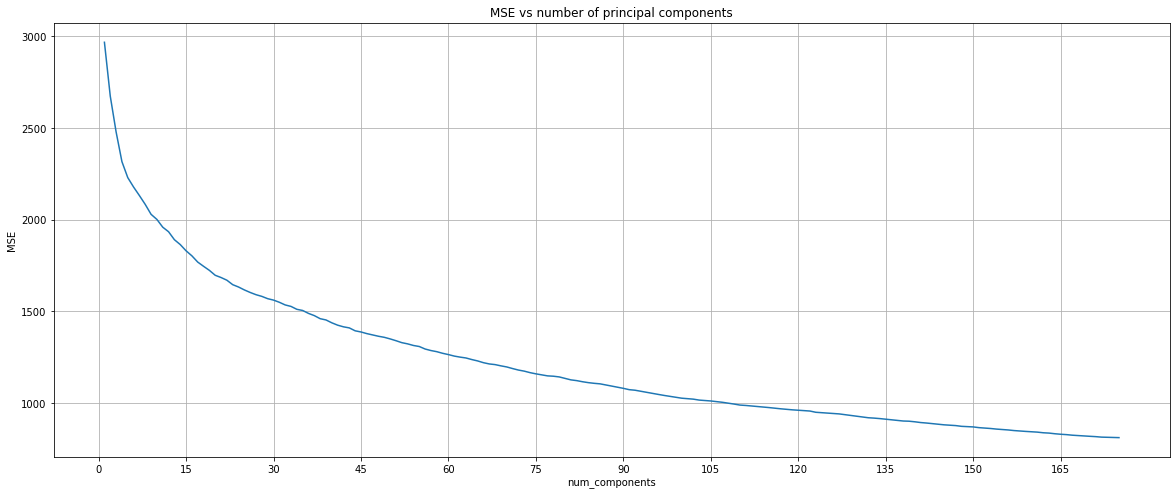

In [18]:
# visualizing mse vs number of principal components

fig, ax = plt.subplots(figsize = (20, 8))
ax.plot(loss[:,0], loss[:, 1])
ax.xaxis.set_ticks(np.arange(0, max_components, 15))
ax.set(xlabel = 'num_components', ylabel = 'MSE', title = 'MSE vs number of principal components')
plt.grid()

### Conclusion:

More the principle components used, better is the accuracy of reconstruction even though the images were unseen.

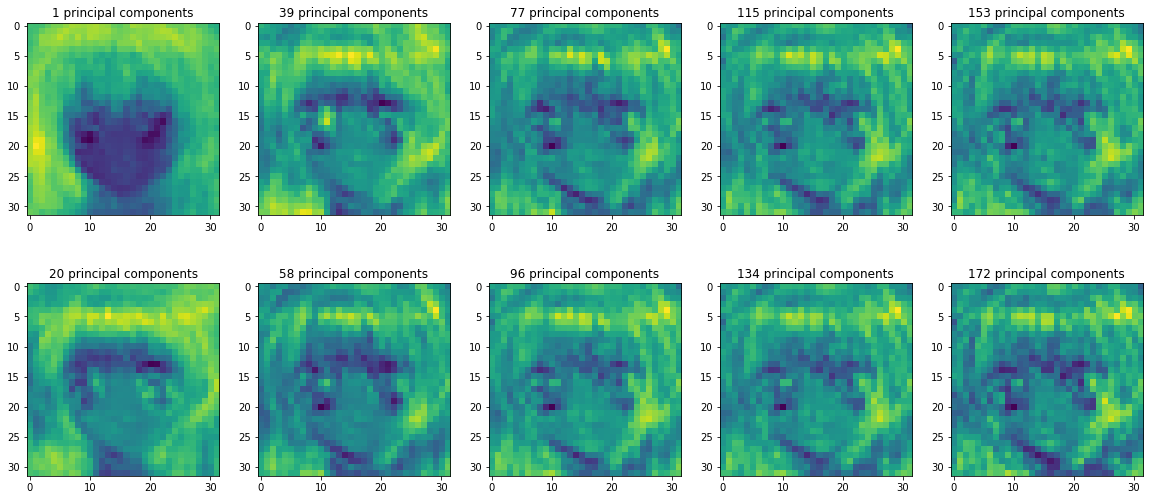

In [19]:
# plotting the reconstructed images

n = 1 # number of double-rows
m = 5 # number of columns
t = 0.9 # 1-t == top space 
b = 0.1 # bottom space      (both in figure coordinates)
msp = 0.3 # minor spacing
sp = 0.8  # major spacing
offs = (1+msp) * (t-b) / (2*n + n*msp + (n-1)*sp) # grid offset
hspace = sp + msp + 1 # height space per grid
gso = GridSpec(n, m, bottom = b+offs, top = t, hspace = hspace)
gse = GridSpec(n, m, bottom = b, top = t-offs, hspace = hspace)
fig = plt.figure(figsize=(20, 8))
axes = []
for i in range(n*m):
    axes.append(fig.add_subplot(gso[i]))
    axes.append(fig.add_subplot(gse[i]))
k = 1
for j in range(10):
    axes[j].set_title('{} principal components'.format(k))
    axes[j].imshow(reconstructions[k, :, 0].reshape(image_size, image_size))
    k += 19
plt.show()

### Points to note:

1.) Projection matrix is learnt from the training data.

2.) Test image is reconstructed from the projection matrix.

3.) As the number of principle components increase, the reconstruction accuracy increases.

4.) Try increasing the number of training samples and notice the changes in MSE. What do you obeserve?

5.) You can also try and increase the image size from 32 to 64 or 128. (Processing time will be longer)

# Instructions

1.) Make a folder named 'PCA' and put your 'PCA.ipynb' file inside it.

2.) Make a folder named as your roll number (all caps) and put the 'PCA' folder inside it.

3.) Zip the folder and upload it on LMS.

4.) Follow the instructions carefully as the evaluation is automated